In [1]:
import numpy as np
from grid_grammar import *
from scipy.stats import entropy 
from tqdm import tqdm 
import pickle 
import matplotlib.pyplot as plt 

In [9]:
all_boards_dict=np.load('all_grammar_boards.npz')
all_boards=np.concatenate([all_boards_dict[k] for k in all_boards_dict.keys()])

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [5]:
def consistent(o,b):
    if (b[np.where(o==0)]!=0).sum()>0:
        return False 
    elif (b[np.where(o==1)]!=1).sum()>0:
        return False 
    else:
        return True 
    
def get_random_proximal_tile(board):

    n=board.shape[0]
    legal=np.zeros((n,n))
    distance=0
    while np.sum(legal)==0:
        #print(distance)
        distance+=1
        red_idx=np.where(board==1)
        for i in range(len(red_idx[0])):
            r=red_idx[0][i]
            c=red_idx[1][i]
            legal[max(r-distance,0):min(r+(distance+1),n),max(c-(distance),0):min(c+(distance+1),n)]=1
        legal=legal*(board==-1).astype('int')
    idxs=np.where(legal==1)
    r=np.random.choice(np.arange(len(idxs[0])))
    return (idxs[0][r],idxs[1][r])

def simulate_random_agent(maze,start,strategies):
    p=[]
    n=maze.shape[0]
    policies=[[] for _ in range(len(strategies))]
    board=np.ones(maze.shape)*-1
    board[start[0],start[1]]=1
    while np.sum(board==1)<np.sum(maze==1):
        assert consistent(board,maze)
        for i,s in enumerate(strategies):
            policies[i].append(s(board)) 
        choice=get_random_proximal_tile(board)
        board[choice[0],choice[1]]=maze[choice[0],choice[1]]
    return np.asarray(policies)
    

    
def episodic_strategy(obs):
    num_memories=np.random.choice(np.arange(7,11))
    all_possible_boards=np.asarray([b for b in all_boards if consistent(obs,b)])
    idxs=np.random.choice(np.arange(len(all_possible_boards)),size=min(num_memories,len(all_possible_boards)),replace=False)
    remembered_boards=all_possible_boards[idxs]
    if len(remembered_boards)==0:
        return np.zeros(obs.shape)
    policy=remembered_boards.sum(axis=0)
    policy[obs==0]=0
    policy[obs==1]=0
    return policy/np.sum(policy)

def episodic_strategy2(obs,history=[]):
    all_possible_boards=np.asarray([b for b in history if consistent(obs,b)])
    if len(all_possible_boards)==0:
        policy=np.ones(obs.shape)
    else:
        policy=np.sum(all_possible_boards,axis=0)
    policy[obs==0]=0
    policy[obs==1]=0
    return policy/np.sum(policy)



def grammar_strategy(obs):
    possible_chains=np.asarray([b for b in all_boards_dict['chain'] if consistent(obs,b)])
    possible_trees=np.asarray([b for b in all_boards_dict['tree'] if consistent(obs,b)])
    possible_loop=np.asarray([b for b in all_boards_dict['loop'] if consistent(obs,b)])
    rule_possibilities=[possible_chains,possible_trees,possible_loop]
    rule_probs=[len(possible_chains)/len(all_boards_dict['chain']),len(possible_trees)/len(all_boards_dict['tree']),len(possible_loop)/len(all_boards_dict['loop'])]
    possible_boards=rule_possibilities[np.argmax(rule_probs)]
    #print(possible_boards)
    policy=possible_boards.sum(axis=0)
    policy[obs==0]=0
    policy[obs==1]=0
    return policy/np.sum(policy)

def extract_before_zeros(arr):
    """
    Extract the portion of a 1D numpy array before it becomes all zeros.
    
    Parameters:
    arr (numpy.ndarray): 1D numpy array
    
    Returns:
    numpy.ndarray: Portion of the array before consecutive zeros begin
    """
    # Iterate through the array to find the first index where
    # all subsequent elements are zero
    for i in range(len(arr)):
        # Check if all elements from this index onwards are zero
        if np.all(arr[i:] == 0):
            return arr[:i]
    
    # If we didn't find a point where all remaining values are 0
    return arr

def find_divergence(board,strat1,strat2,iters=100):
    all_kls=[]
    for _ in (range(iters)):
        possible_starts=np.vstack(np.where(board==1)).T
        start=possible_starts[np.random.choice(np.arange(len(possible_starts)))]
        simulation=simulate_random_agent(board,start,[strat1,strat2])
        kl=extract_before_zeros(np.asarray([entropy(pk=simulation[0,i].flatten()+1e-9,qk=simulation[1,i].flatten()+1e-9) for i in range(simulation.shape[1])]))
        if len(kl)==0:
            all_kls.append(0)
        else:
            all_kls.append(kl.mean())
    return np.asarray(all_kls).mean()

In [4]:
shuffled_boards=all_boards.copy()
np.random.shuffle(shuffled_boards)

In [ ]:
from tqdm import tqdm
history=[]
divergences=[]
for trial in tqdm(range(1000)):
    board=shuffled_boards[trial%len(shuffled_boards)]
    possible_starts=np.vstack(np.where(board==1)).T
    start=possible_starts[np.random.choice(np.arange(len(possible_starts)))]
    episodic_strat_singleton=lambda obs: episodic_strategy2(obs,history=history)
    simulation=simulate_random_agent(board,start,[grammar_strategy,episodic_strat_singleton])
    kl=extract_before_zeros(np.asarray([entropy(pk=simulation[0,i].flatten()+1e-9,qk=simulation[1,i].flatten()+1e-9) for i in range(simulation.shape[1])]))
    divergences.append(np.mean(kl))
    history.append(board.copy())


  6%|▋         | 65/1000 [00:06<01:25, 10.96it/s]/tmp/ipykernel_2809441/2412206972.py:63: RuntimeWarning: invalid value encountered in divide
  return policy/np.sum(policy)
 50%|█████     | 503/1000 [01:10<01:21,  6.12it/s]/scratch/gpfs/sreejank/dreamerv3torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/scratch/gpfs/sreejank/dreamerv3torch/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 64%|██████▍   | 644/1000 [01:37<01:33,  3.80it/s]/tmp/ipykernel_2809441/2412206972.py:78: RuntimeWarning: invalid value encountered in divide
  return policy/np.sum(policy)
100%|██████████| 1000/1000 [03:01<00:00,  5.50it/s]


: 

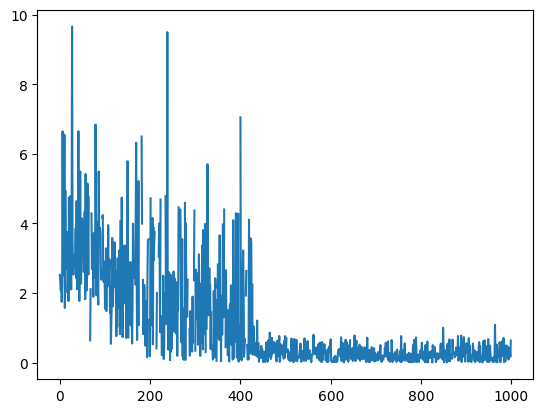

: 

In [ ]:
plt.plot(divergences)

In [5]:
human_choices=np.load('/tigress/sreejank/metarl/compositional_choices_human.npy',allow_pickle=True)
human_starts=np.load('/tigress/sreejank/metarl/held_out/all_starts.npy')
human_boards=np.load('/tigress/sreejank/metarl/held_out/all.npy').reshape((-1,7,7))

In [6]:
orders=np.load('/tigress/sreejank/metarl/orders_compositional.npy')


In [ ]:
orders=np.load('/tigress/sreejank/metarl/orders_compositional.npy')

def compare_likelihoods_single_trial(choices,board,start,history=[]):
    obs=np.ones(board.shape)*-1
    obs[start[0],start[1]]=1
    episodic_likelihood=[]
    grammar_likelihood=[]
    for choice in choices:
        assert consistent(obs,board)
        grammar_policy=grammar_strategy(obs)
        episodic_policy=episodic_strategy2(obs,history=history)
        episodic_likelihood.append(episodic_policy[choice[0],choice[1]])
        grammar_likelihood.append(grammar_policy[choice[0],choice[1]])
    return np.asarray(episodic_likelihood),np.asarray(grammar_likelihood)

def compare_likelihoods_over_trials(individual_choices,order):
    history=[]
    episodic_likelihoods=[]
    grammar_likelihoods=[]
    ordered_boards=human_boards.copy()
    ordered_boards=ordered_boards[order]
    ordered_starts=human_starts.copy()
    ordered_starts=ordered_starts[order]
    for i in range(len(human_boards)):
        e,g=compare_likelihoods_single_trial(individual_choices[i],ordered_boards[i],ordered_starts[i],history=history)
        history.append(ordered_boards[i].copy())
        episodic_likelihoods.append(e)
        grammar_likelihoods.append(g)
    return episodic_likelihoods,grammar_likelihoods


In [22]:
participant=[]
time=[]
trial=[]
step=[]
likelihood=[]
model=[]

for i in tqdm(range(len(human_choices))):
    e,g=compare_likelihoods_over_trials(human_choices[i],orders[i])
    t=0
    for j in range(len(e)):
        for k in range(len(e[j])):
            participant.append(i)
            time.append(t)
            trial.append(j)
            step.append(k)
            likelihood.append(e[j][k])
            model.append("Episodic")

            participant.append(i)
            time.append(t)
            trial.append(j)
            step.append(k)
            likelihood.append(g[j][k])
            model.append("Semantic")
            
            t+=1




    
    

100%|██████████| 25/25 [00:47<00:00,  1.89s/it]


In [23]:
import pandas as pd
import seaborn as sns 
df=pd.DataFrame(dict(participant=participant,time=time,trial=trial,step=step,model=model,likelihood=likelihood))
df

,participant,time,trial,step,model,likelihood
0,0,0,0,0,Episodic,0.020833
1,0,0,0,0,Semantic,0.040000
2,0,1,0,1,Episodic,0.020833
3,0,1,0,1,Semantic,0.022500
4,0,2,0,2,Episodic,0.020833
...,...,...,...,...,...,...
13629,24,284,23,10,Semantic,0.053619
13630,24,285,23,11,Episodic,0.066667
13631,24,285,23,11,Semantic,0.092493
13632,24,286,23,12,Episodic,0.000000


<Axes: xlabel='time', ylabel='likelihood'>

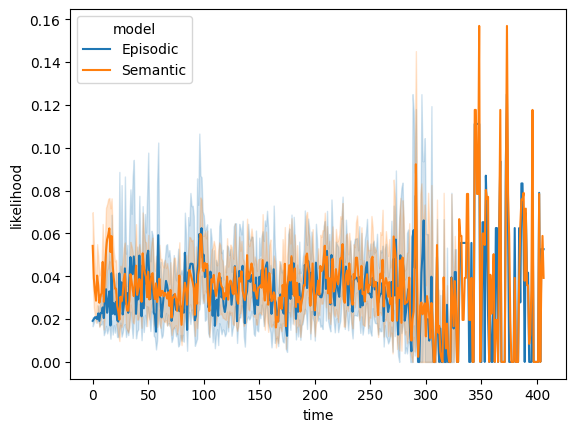

In [24]:
sns.lineplot(data=df,x='time',y='likelihood',hue='model')

In [9]:
from scipy.stats import pearsonr 
for i in range(len(human_choices)):
    gap=compare_likelihoods_over_trials(human_choices[i])
    fig,axarr=plt.subplots(figsize=(24,24),ncols=6,nrows=4)
    for row in range(4):
        for col in range(6):
            j=4*row+col
            axarr[row][col].plot(gap[j])
            axarr[row][col].set_title("Trial "+str(j))
    break


TypeError: compare_likelihoods_over_trials() missing 1 required positional argument: 'order'

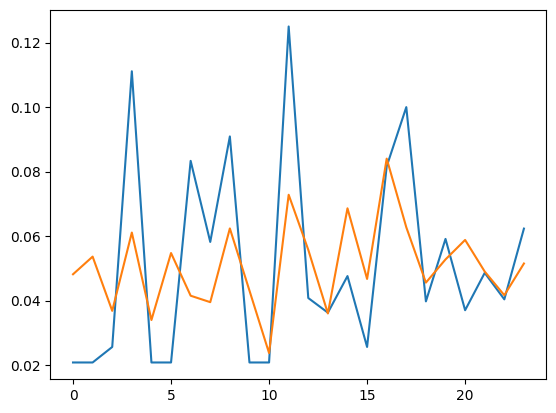

In [73]:
plt.figure()
plt.plot(e)
plt.plot(g)

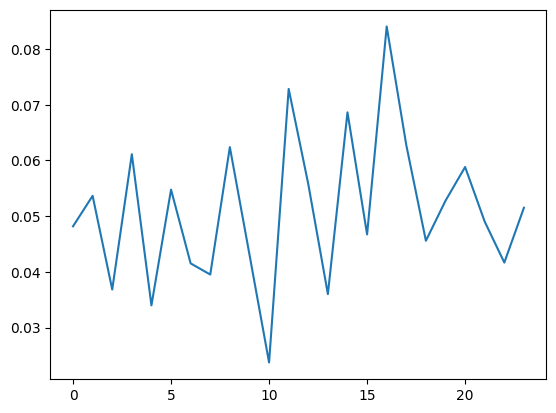

In [72]:
plt.plot(g)

In [7]:
import torch

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class MazeCNN(nn.Module):
    def __init__(self, embedding_dim=32):
        super(MazeCNN, self).__init__()
        # Simple CNN architecture
        # Input: 1 channel (observation with -1, 0, 1) -> Encode to 3 channels (one-hot)
        # then process through convolutional layers
        
        self.embedding_dim = embedding_dim
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, embedding_dim, kernel_size=3, padding=1)
        
        # Decoder layers (to reconstruct the full maze)
        self.deconv1 = nn.Conv2d(embedding_dim, 32, kernel_size=3, padding=1)
        self.deconv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.deconv3 = nn.Conv2d(16, 1, kernel_size=3, padding=1)  # Output: probabilities for each tile
        
    def encode(self, x):
        """
        Encode an observation into an embedding
        x: batch of observations [B, 7, 7] with values -1, 0, 1
        """
        # Convert to one-hot encoding
        x_onehot = self._to_onehot(x)  # [B, 3, 7, 7]
        
        # Forward pass through encoder
        x = F.relu(self.conv1(x_onehot))  # [B, 16, 7, 7]
        x = F.relu(self.conv2(x))  # [B, 32, 7, 7]
        embedding = self.conv3(x)  # [B, embedding_dim, 7, 7]
        
        return embedding
        
    def decode(self, embedding):
        """
        Decode an embedding into a full maze prediction
        """
        x = F.relu(self.deconv1(embedding))  # [B, 32, 7, 7]
        x = F.relu(self.deconv2(x))  # [B, 16, 7, 7]
        logits = self.deconv3(x)  # [B, 1, 7, 7]
        
        return logits.squeeze(1)  # [B, 7, 7]
    
    def forward(self, x):
        """
        Forward pass through encoder and decoder
        x: batch of observations [B, 7, 7] with values -1, 0, 1
        """
        embedding = self.encode(x)
        logits = self.decode(embedding)
        return logits
    
    def _to_onehot(self, x):
        """
        Convert observations with values -1, 0, 1 to one-hot encoding
        x: [B, 7, 7]
        returns: [B, 3, 7, 7]
        """
        batch_size = x.size(0)
        # Create one-hot tensors
        x_onehot = torch.zeros(batch_size, 3, 7, 7, device=x.device)
        
        # Set the appropriate channels
        x_onehot[:, 0, :, :] = (x == -1)  # Channel 0: covered tiles (-1)
        x_onehot[:, 1, :, :] = (x == 0)   # Channel 1: revealed 0s
        x_onehot[:, 2, :, :] = (x == 1)   # Channel 2: revealed 1s
        
        return x_onehot.float()
    
    def compute_similarity(self, obs1, obs2):
        """
        Compute similarity between two observations using their embeddings
        obs1, obs2: observations [7, 7] with values -1, 0, 1
        """
        # Add batch dimension if necessary
        if obs1.dim() == 2:
            obs1 = obs1.unsqueeze(0)
        if obs2.dim() == 2:
            obs2 = obs2.unsqueeze(0)
        
        # Compute embeddings
        emb1 = self.encode(obs1)  # [1, embedding_dim, 7, 7]
        emb2 = self.encode(obs2)  # [1, embedding_dim, 7, 7]
        
        # Flatten embeddings
        emb1_flat = emb1.view(1, -1)  # [1, embedding_dim * 7 * 7]
        emb2_flat = emb2.view(1, -1)  # [1, embedding_dim * 7 * 7]
        
        # Compute cosine similarity
        similarity = F.cosine_similarity(emb1_flat, emb2_flat)
        
        return similarity.item()
    

class MazeEpisodicMemoryModel(nn.Module):
    def __init__(self, grid_size=7, memory_size=10, temperature=1.0):
        """
        Initialize the episodic memory model for maze game.
        
        Args:
            grid_size: Size of the maze grid (grid_size x grid_size)
            memory_size: Number of previous mazes to remember (N)
            init_temperature: Initial value for softmax temperature parameter
        """
        super(MazeEpisodicMemoryModel, self).__init__()
        
        self.grid_size = grid_size
        self.memory_size = memory_size
        
        # Memory structure:
        # For each maze, we store:
        # 1. The complete maze
        # 2. A list of all observations seen for that maze
        self.memory = []  # List of (maze, [observations]) tuples

        self.embedding_dict={}
        self.cnn=MazeCNN(embedding_dim=16)
        self.cnn.load_state_dict(torch.load('mazecnn_weights.pt'))
        self.cnn.cpu()
        
        
        # Learnable temperature parameter for softmax
        self.temperature = temperature
        
    def compute_similarity(self, current_obs, stored_obs):
        """
        Compute similarity between current observation and stored observation.
        
        Args:
            current_obs: Current observation tensor [grid_size, grid_size]
            stored_obs: Stored observation tensor [grid_size, grid_size]
            
        Returns:
            similarity: A scalar representing similarity
        """
        with torch.no_grad():
            if tuple(current_obs.flatten()) in self.embedding_dict.keys():
                E1=self.embedding_dict[tuple(current_obs.flatten())]
            else:
                E1=self.cnn.encode((current_obs.reshape((1,7,7))))
                self.embedding_dict[tuple(current_obs.flatten())]=E1 

            if tuple(stored_obs.flatten()) in self.embedding_dict.keys():
                E2=self.embedding_dict[tuple(stored_obs.flatten())]
            else:
                E2=self.cnn.encode((stored_obs.reshape((1,7,7))))
                self.embedding_dict[tuple(stored_obs.flatten())]=E2  
        
        emb1_flat = E1.view(1, -1)  # [1, embedding_dim * 7 * 7]
        emb2_flat = E2.view(1, -1)  # [1, embedding_dim * 7 * 7]
        
        # Compute cosine similarity
        similarity = F.cosine_similarity(emb1_flat, emb2_flat)
        
        return similarity.item()
    
    def is_consistent(self, current_obs, stored_maze):
        """
        Check if the stored maze is consistent with current observation.
        
        Args:
            current_obs: Current observation tensor [grid_size, grid_size]
            stored_maze: Previously stored maze [grid_size, grid_size]
            
        Returns:
            Boolean: True if consistent, False otherwise
        """
        # Get non-covered indices in current observation
        revealed_indices = (current_obs != -1)
        
        # Check if values match at revealed positions
        if torch.any(current_obs[revealed_indices] != stored_maze[revealed_indices]):
            return False
        
        return True
    
    def compute_likelihood(self, observation):
        """
        Compute likelihood of clicking each position based on episodic memory.
        
        Args:
            observation: Current game observation [grid_size, grid_size]
            
        Returns:
            likelihood: Likelihood map for each position [grid_size, grid_size]
        """
        # Convert observation to tensor if not already
        if not isinstance(observation, torch.Tensor):
            observation = torch.tensor(observation, dtype=torch.float32)
        
        # Initialize likelihood map with zeros
        likelihood = torch.zeros((self.grid_size, self.grid_size), dtype=torch.float32)
        # If no memory yet, use uniform likelihood for covered tiles
        if len(self.memory) == 0:
            covered_indices = (observation == -1)
            if torch.any(covered_indices):
                likelihood[covered_indices] = 1.0 / torch.sum(covered_indices).item()
            return likelihood
        
        # Find all consistent mazes and compute similarities
        consistent_mazes = []
        all_similarities = []
        
        # First pass: collect all consistent mazes and compute similarities
        for maze_idx, (stored_maze, stored_observations) in enumerate(self.memory):
            # Check if maze is consistent with current observation
            if self.is_consistent(observation, stored_maze):
                # Compute similarity with each stored observation of this maze
                for obs_idx, stored_obs in enumerate(stored_observations):
                    similarity = self.compute_similarity(observation, stored_obs)
                    consistent_mazes.append((maze_idx, obs_idx))
                    all_similarities.append(similarity)
        
        # If no consistent mazes found, use uniform distribution
        if not consistent_mazes:
            covered_indices = (observation == -1)
            if torch.any(covered_indices):
                likelihood[covered_indices] = 1.0 / torch.sum(covered_indices).item()
            return likelihood
        # Convert similarities to tensor and apply softmax with temperature
        similarities_tensor = torch.tensor(all_similarities)
        weights = F.softmax(similarities_tensor / self.temperature, dim=0)
        
        # Apply the weighted sum based on softmax weights
        for idx, (maze_idx, _) in enumerate(consistent_mazes):
            stored_maze, _ = self.memory[maze_idx]
            weight = weights[idx].item()
            
            # Apply weights to covered tiles
            covered_indices = (observation == -1)
            likelihood[covered_indices] += weight * stored_maze[covered_indices]
        
        # Zero out already revealed tiles
        revealed_indices = (observation != -1)
        likelihood[revealed_indices] = 0.0
        
        return likelihood
    
    def update_memory(self, maze, observation):
        """
        Update episodic memory with a new maze and its observation.
        
        Args:
            maze: Complete maze array [grid_size, grid_size]
            observation: Current observation [grid_size, grid_size]
        """
        # Convert to tensors if not already
        if not isinstance(maze, torch.Tensor):
            maze = torch.tensor(maze, dtype=torch.float32)
        if not isinstance(observation, torch.Tensor):
            observation = torch.tensor(observation, dtype=torch.float32)
        
        # Check if this maze is already in memory
        for i, (stored_maze, stored_observations) in enumerate(self.memory):
            if torch.all(stored_maze == maze):
                # Maze already exists, add this observation to its list
                self.memory[i][1].append(observation.clone())
                return
        
        # This is a new maze, add it with its first observation
        self.memory.append((maze.clone(), [observation.clone()]))
        
        # Keep only the most recent N mazes
        if len(self.memory) > self.memory_size:
            self.memory.pop(0)

    def log_likelihood(self, observations, actions, maze):
        """
        Compute the negative log-likelihood of the observed actions given the observations.
        
        Args:
            observations: List of observations [num_steps, grid_size, grid_size]
            actions: List of (i,j) action coordinates taken [num_steps, 2]
            maze: The complete maze for this episode
            
        Returns:
            neg_log_likelihood: The negative log-likelihood of the observed actions
        """
        neg_log_likelihood = 0.0
        
        for t in range(len(observations)):
            obs = observations[t]
            action = actions[t]
            i, j = action
            
            # Compute likelihood map
            likelihood_map = self.compute_likelihood(obs)
            
            
            # Get likelihood of the chosen action
            action_likelihood = likelihood_map[i, j].item()
            
            # Add to negative log-likelihood (avoid log(0))
            if action_likelihood > 0:
                neg_log_likelihood -= torch.log(torch.tensor(action_likelihood))
            else:
                neg_log_likelihood += 100.0  # Large penalty for zero likelihood actions
            
            # If this is not the last observation, create the next observation
            # by revealing the tile at the action location
            if t < len(observations) - 1:
                # This is just for verification - in practice, the next observation
                # should already be in the observations list
                next_obs = obs.clone()
                next_obs[i, j] = maze[i, j]
                assert torch.all(next_obs == observations[t+1]), "Next observation mismatch"
        
        return neg_log_likelihood

def get_model_likelihood(model,data):
    neg_log_likelihood=0.0
    for maze, observations, actions in tqdm(data):
        neg_log_likelihood+= model.log_likelihood(observations, actions, maze)
        
        for obs in observations:
            model.update_memory(maze, obs)
    return neg_log_likelihood




In [9]:
# Create a model with memory size 5 and initial temperature 1.0
model = MazeEpisodicMemoryModel(grid_size=7, memory_size=5, temperature=1.0)

# Example data creation - in practice, you would load real game data
grid_size = 7
num_games = 25
sample_data = []

for _ in range(num_games):
    # Generate a random maze (0s and 1s)
    maze = torch.randint(0, 2, (grid_size, grid_size), dtype=torch.float32)
    
    # Simulate a game: start with all covered (-1) and gradually reveal
    num_steps = 10
    observations = []
    actions = []
    
    # Initial observation (all covered)
    current_obs = torch.full((grid_size, grid_size), -1.0)
    observations.append(current_obs.clone())
    
    for step in range(num_steps):
        # Random action (in real data, this would be the player's choice)
        while True:
            i, j = torch.randint(0, grid_size, (2,))
            if current_obs[i, j] == -1:  # Only choose covered tiles
                break
        
        actions.append((i.item(), j.item()))
        
        # Update observation by revealing the tile
        current_obs[i, j] = maze[i, j]
        
        # Add the updated observation if not the last step
        if step < num_steps - 1:
            observations.append(current_obs.clone())
    
    sample_data.append((maze, observations, actions))

get_model_likelihood(model,sample_data)

/tmp/ipykernel_516261/216677793.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.cnn.load_state_dict(torch.load('mazecnn_weights.pt'))
  8%|▊         | 2/25 [00:06

KeyboardInterrupt: 

In [ ]:
memory_sizes=[5,10,25]
temperature=[0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

lik=np.zeros((3,6))

for i,mem in enumerate(memory_sizes):
    for j,temp in tqdm(enumerate(temperature)):
        model = MazeEpisodicMemoryModel(grid_size=7, memory_size=mem, temperature=temp)
        lik[i,j]=get_model_likelihood(model,sample_data)


6it [01:37, 16.28s/it]
6it [01:37, 16.29s/it]
6it [01:39, 16.55s/it]


In [66]:
#model = MazeEpisodicMemoryModel(grid_size=7, memory_size=mem, temperature=temp)
get_model_likelihood(model,sample_data)

tensor([[0.7500, 0.7500, 1.0000, 0.5000, 0.0000, 0.7500, 0.7500],
        [0.5000, 0.5000, 0.7500, 0.2500, 0.7500, 1.0000, 0.2500],
        [0.7500, 0.7500, 0.7500, 0.7500, 1.0000, 0.5000, 0.7500],
        [0.2500, 0.2500, 0.0000, 0.5000, 0.5000, 0.2500, 0.5000],
        [0.0000, 1.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.7500],
        [0.5000, 0.2500, 1.0000, 0.2500, 0.5000, 0.7500, 0.7500],
        [0.2500, 0.7500, 0.7500, 0.0000, 0.7500, 0.2500, 0.2500]])
tensor([[1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000],
        [0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000]])


KeyboardInterrupt: 

In [64]:
len(model.memory)

3

In [10]:
from task_generating_network import *

In [11]:
network=Net()
network.load_state_dict(torch.load('/tigress/sreejank/metarl/task_generator.pt'))

/tmp/ipykernel_516261/2842220977.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict(torch.load('/tigress/sreejank/metarl/task_generator.pt'))


<All keys matched successfully>

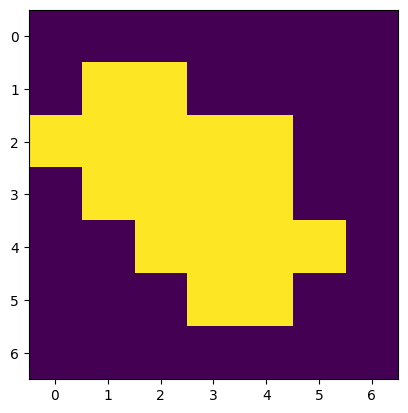

In [12]:
plt.imshow(gibbs_sample(network=network).reshape((7,7)))

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque

class MazeEpisodicMemoryModel(nn.Module):
    def __init__(self, grid_size=7, memory_size=10, temperature=1.0):
        """
        Initialize the episodic memory model for maze game.
        
        Args:
            grid_size: Size of the maze grid (grid_size x grid_size)
            memory_size: Number of previous mazes to remember (N)
            temperature: Value for softmax temperature parameter
        """
        super(MazeEpisodicMemoryModel, self).__init__()
        
        self.grid_size = grid_size
        self.memory_size = memory_size
        
        # Memory structure:
        # For each maze, we store:
        # 1. The complete maze
        # 2. A list of all observations seen for that maze
        self.memory = deque(maxlen=memory_size)  # Using deque for O(1) popping
        
        # Cache for embeddings to avoid recomputing
        self.embedding_dict = {}
        
        # Load pre-trained CNN
        self.cnn = MazeCNN(embedding_dim=16)
        self.cnn.load_state_dict(torch.load('mazecnn_weights.pt'))
        self.cnn.cpu()
        self.cnn.eval()  # Set to evaluation mode
        
        # Fixed temperature parameter
        self.temperature = temperature
        
    def get_embedding(self, obs):
        """
        Get embedding for an observation, using cache if available.
        
        Args:
            obs: Observation tensor [grid_size, grid_size]
            
        Returns:
            embedding: Tensor of shape [embedding_dim * grid_size * grid_size]
        """
        obs_key = tuple(obs.flatten().tolist())
        
        if obs_key in self.embedding_dict:
            return self.embedding_dict[obs_key]
        
        with torch.no_grad():  # Disable gradient calculation for inference
            emb = self.cnn.encode(obs.reshape(1, self.grid_size, self.grid_size))
            self.embedding_dict[obs_key] = emb
        
        return emb
    
    def batch_check_consistency(self, observation, mazes):
        """
        Fully vectorized consistency check for multiple mazes at once.
        
        Args:
            observation: Current observation tensor [grid_size, grid_size]
            mazes: Tensor of mazes [num_mazes, grid_size, grid_size]
            
        Returns:
            mask: Boolean tensor indicating which mazes are consistent [num_mazes]
        """
        # Get revealed positions mask
        revealed_mask = (observation != -1)
        
        if not torch.any(revealed_mask):
            # If no revealed tiles, all mazes are consistent
            return torch.ones(len(mazes), dtype=torch.bool)
        
        # Flatten everything for easier operations
        obs_flat = observation.flatten()  # [49]
        mazes_flat = mazes.reshape(mazes.size(0), -1)  # [num_mazes, 49]
        revealed_mask_flat = revealed_mask.flatten()  # [49]
        
        # Extract only the revealed positions for comparison
        revealed_positions = torch.nonzero(revealed_mask_flat, as_tuple=True)[0]  # indices where tiles are revealed
        
        # Extract values at revealed positions
        revealed_obs_values = obs_flat[revealed_positions]  # [num_revealed]
        revealed_maze_values = mazes_flat[:, revealed_positions]  # [num_mazes, num_revealed]
        
        # Check equality across all revealed positions at once
        # For each maze, we get a boolean tensor of shape [num_revealed]
        equality_checks = (revealed_maze_values == revealed_obs_values.unsqueeze(0))
        
        # A maze is consistent if ALL revealed positions match
        consistent_mask = torch.all(equality_checks, dim=1)  # [num_mazes]
        
        return consistent_mask
        
    def compute_likelihood(self, observation):
        """
        Fully vectorized computation of likelihood based on episodic memory.
        
        Args:
            observation: Current game observation [grid_size, grid_size]
            
        Returns:
            likelihood: Likelihood map for each position [grid_size, grid_size]
        """
        # Convert observation to tensor if not already
        if not isinstance(observation, torch.Tensor):
            observation = torch.tensor(observation, dtype=torch.float32)
        
        # Initialize likelihood map with zeros
        likelihood = torch.zeros((self.grid_size, self.grid_size), dtype=torch.float32)
        
        # Identify covered indices once
        covered_indices = (observation == -1)
        
        # If no memory yet or no covered tiles, use uniform likelihood for covered tiles
        if len(self.memory) == 0 or not torch.any(covered_indices):
            if torch.any(covered_indices):
                likelihood[covered_indices] = 1.0 / torch.sum(covered_indices).item()
            return likelihood
        
        # Get all mazes and check which ones are consistent
        all_mazes = [m[0] for m in self.memory]
        mazes_tensor = torch.stack(all_mazes) if all_mazes else torch.tensor([])
        
        if len(mazes_tensor) == 0:
            # No mazes in memory
            if torch.any(covered_indices):
                likelihood[covered_indices] = 1.0 / torch.sum(covered_indices).item()
            return likelihood
        
        # Get consistent maze indices using vectorized check
        consistent_mask = self.batch_check_consistency(observation, mazes_tensor)
        consistent_indices = torch.nonzero(consistent_mask, as_tuple=True)[0]
        
        if len(consistent_indices) == 0:
            # No consistent mazes found
            if torch.any(covered_indices):
                likelihood[covered_indices] = 1.0 / torch.sum(covered_indices).item()
            return likelihood
        
        # Get embedding for current observation
        current_emb = self.get_embedding(observation)
        current_emb_flat = current_emb.view(-1)
        
        # Collect all consistent observations and their maze indices
        all_consistent_obs = []
        maze_indices = []
        
        # Only collect observations from consistent mazes
        for idx in consistent_indices:
            maze_idx = idx.item()
            maze, observations = self.memory[maze_idx]
            
            for stored_obs in observations:
                all_consistent_obs.append(stored_obs)
                maze_indices.append(maze_idx)
        
        # If no observations found
        if not all_consistent_obs:
            if torch.any(covered_indices):
                likelihood[covered_indices] = 1.0 / torch.sum(covered_indices).item()
            return likelihood
        
        # Get embeddings for all observations at once
        all_obs_embeddings = []
        for obs in all_consistent_obs:
            all_obs_embeddings.append(self.get_embedding(obs).view(-1))
        
        # Stack embeddings into a single tensor
        all_embs_tensor = torch.stack(all_obs_embeddings)  # [num_obs, embedding_dim*7*7]
        
        # Compute all cosine similarities at once
        # Normalize current embedding
        current_emb_norm = F.normalize(current_emb_flat.unsqueeze(0), p=2, dim=1)
        
        # Normalize all observation embeddings
        all_embs_norm = F.normalize(all_embs_tensor, p=2, dim=1)
        
        # Compute dot product for all pairs at once
        similarities = torch.mm(current_emb_norm, all_embs_norm.t()).squeeze()
        
        # Apply softmax with temperature to similarities
        weights = F.softmax(similarities / self.temperature, dim=0)
        
        # Calculate weighted sum for each maze
        maze_weight_sum = {}
        
        # Aggregate weights by maze
        for i, maze_idx in enumerate(maze_indices):
            if maze_idx not in maze_weight_sum:
                maze_weight_sum[maze_idx] = 0.0
            maze_weight_sum[maze_idx] += weights[i].item()
        
        # Apply weighted sum to get likelihood
        for maze_idx, weight in maze_weight_sum.items():
            maze = self.memory[maze_idx][0]
            likelihood[covered_indices] += weight * maze[covered_indices]
        
        likelihood=likelihood/torch.sum(likelihood)
        
        return likelihood
    
    def update_memory(self, maze, observation):
        """
        Update episodic memory with a new maze and its observation.
        
        Args:
            maze: Complete maze array [grid_size, grid_size]
            observation: Current observation [grid_size, grid_size]
        """
        # Convert to tensors if not already
        if not isinstance(maze, torch.Tensor):
            maze = torch.tensor(maze, dtype=torch.float32)
        if not isinstance(observation, torch.Tensor):
            observation = torch.tensor(observation, dtype=torch.float32)
        
        # Check if this maze is already in memory
        for i, (stored_maze, stored_observations) in enumerate(self.memory):
            if torch.all(stored_maze == maze):
                # Maze already exists, add this observation to its list
                self.memory[i][1].append(observation.clone())
                return
        
        # This is a new maze, add it with its first observation
        self.memory.append((maze.clone(), [observation.clone()]))
    
    def batch_update_memory(self, maze, observations):
        """
        Update memory with multiple observations for a maze at once.
        
        Args:
            maze: Complete maze array [grid_size, grid_size]
            observations: List of observations for this maze
        """
        # Convert to tensors if not already
        if not isinstance(maze, torch.Tensor):
            maze = torch.tensor(maze, dtype=torch.float32)
        
        # Convert all observations to tensors
        obs_tensors = []
        for obs in observations:
            if not isinstance(obs, torch.Tensor):
                obs = torch.tensor(obs, dtype=torch.float32)
            obs_tensors.append(obs.clone())
        
        # Check if this maze is already in memory
        for i, (stored_maze, stored_observations) in enumerate(self.memory):
            if torch.all(stored_maze == maze):
                # Maze already exists, add these observations to its list
                self.memory[i][1].extend(obs_tensors)
                return
        
        # This is a new maze, add it with all its observations
        self.memory.append((maze.clone(), obs_tensors))

    def log_likelihood(self, observations, actions, maze):
        """
        Compute the negative log-likelihood of the observed actions given the observations.
        
        Args:
            observations: List of observations [num_steps, grid_size, grid_size]
            actions: List of (i,j) action coordinates taken [num_steps, 2]
            maze: The complete maze for this episode
            
        Returns:
            neg_log_likelihood: The negative log-likelihood of the observed actions
        """
        neg_log_likelihood = 0.0
        
        for t in range(len(observations)):
            obs = observations[t]
            action = actions[t]
            i, j = action
            
            # Compute likelihood map
            likelihood_map = self.compute_likelihood(obs)
            
            # Get likelihood of the chosen action
            action_likelihood = likelihood_map[i, j].item()
            
            # Add to negative log-likelihood (avoid log(0))
            if action_likelihood > 0:
                neg_log_likelihood -= torch.log(torch.tensor(action_likelihood))
            else:
                neg_log_likelihood += 100.0  # Large penalty for zero likelihood actions
            
            # Skip verification for speed
        
        return neg_log_likelihood

def get_model_likelihood(model, data, batch_update=True):
    """
    Calculate the likelihood of the model on the given data.
    
    Args:
        model: The MazeEpisodicMemoryModel
        data: List of (maze, observations, actions) tuples
        batch_update: Whether to update memory in batches
        
    Returns:
        neg_log_likelihood: The negative log-likelihood of the data
    """
    neg_log_likelihood = 0.0
    
    for maze, observations, actions in data:
        # Calculate log likelihood
        neg_log_likelihood += model.log_likelihood(observations, actions, maze)
        
        # Update memory - more efficient to do in batch
        if batch_update:
            model.batch_update_memory(maze, observations)
        else:
            for obs in observations:
                model.update_memory(maze, obs)
    
    return neg_log_likelihood

In [14]:
# Create a model with memory size 5 and initial temperature 1.0
model = MazeEpisodicMemoryModel(grid_size=7, memory_size=15, temperature=0.1)

# Example data creation - in practice, you would load real game data
grid_size = 7
num_games = 25
sample_data = []

for _ in range(num_games):
    # Generate a random maze (0s and 1s)
    maze = torch.randint(0, 2, (grid_size, grid_size), dtype=torch.float32)
    
    # Simulate a game: start with all covered (-1) and gradually reveal
    num_steps = 10
    observations = []
    actions = []
    
    # Initial observation (all covered)
    current_obs = torch.full((grid_size, grid_size), -1.0)
    observations.append(current_obs.clone())
    
    for step in range(num_steps):
        # Random action (in real data, this would be the player's choice)
        while True:
            i, j = torch.randint(0, grid_size, (2,))
            if current_obs[i, j] == -1:  # Only choose covered tiles
                break
        
        actions.append((i.item(), j.item()))
        
        # Update observation by revealing the tile
        current_obs[i, j] = maze[i, j]
        
        # Add the updated observation if not the last step
        if step < num_steps - 1:
            observations.append(current_obs.clone())
    
    sample_data.append((maze, observations, actions))

get_model_likelihood(model,sample_data)

/tmp/ipykernel_516261/3986524815.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.cnn.load_state_dict(torch.load('mazecnn_weights.pt'))


KeyboardInterrupt: 

In [122]:
# Create a model with memory size 5 and initial temperature 1.0
model = MazeEpisodicMemoryModel(grid_size=7, memory_size=15, temperature=0.1)

# Example data creation - in practice, you would load real game data
grid_size = 7
num_games = 25
sample_data = []

for _ in range(num_games):
    # Generate a random maze (0s and 1s)
    maze = torch.randint(0, 2, (grid_size, grid_size), dtype=torch.float32)
    
    # Simulate a game: start with all covered (-1) and gradually reveal
    num_steps = 10
    observations = []
    actions = []
    
    # Initial observation (all covered)
    current_obs = torch.full((grid_size, grid_size), -1.0)
    observations.append(current_obs.clone())
    
    for step in range(num_steps):
        # Random action (in real data, this would be the player's choice)
        while True:
            i, j = torch.randint(0, grid_size, (2,))
            if current_obs[i, j] == -1:  # Only choose covered tiles
                break
        
        actions.append((i.item(), j.item()))
        
        # Update observation by revealing the tile
        current_obs[i, j] = maze[i, j]
        
        # Add the updated observation if not the last step
        if step < num_steps - 1:
            observations.append(current_obs.clone())
    
    sample_data.append((maze, observations, actions))

get_model_likelihood(model,sample_data)

/tmp/ipykernel_638626/1337518557.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.cnn.load_state_dict(torch.load('mazecnn_weights.pt'))
100%|██████████| 25/25 [01:1

tensor(2944.1350)

In [15]:
human_choices=np.load('/tigress/sreejank/metarl/compositional_choices_human.npy',allow_pickle=True)
human_starts=np.load('/tigress/sreejank/metarl/held_out/all_starts.npy')
human_boards=np.load('/tigress/sreejank/metarl/held_out/all.npy').reshape((-1,7,7))

orders=np.load('/tigress/sreejank/metarl/orders_compositional.npy')





In [ ]:
from scipy.stats import entropy
def KL(P,Q):
     epsilon = 0.00001

     # You may want to instead make copies to avoid changing the np arrays.
     P = P+epsilon
     Q = Q+epsilon

     divergence = np.sum(P*np.log(P/Q))
     return divergence



/scratch/gpfs/sreejank/dreamerv3torch/lib/python3.9/site-packages/scipy/stats/_entropy.py:77: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


2.4901108117930493

In [35]:
participant=[]
time=[]
trial_num=[]
step=[]
likelihood=[]
model=[]
kl_divergence=[]
grid_size=7

for subj in range(25):
    print("Subj",subj)
    board_lst=human_boards.copy()[orders[subj]]
    start_lst=human_starts.copy()[orders[subj]]
    episodic_model = MazeEpisodicMemoryModel(grid_size=7, memory_size=25, temperature=1)
    t=0
    for trial in range(24):
        print("Trial",trial)
        maze=board_lst[trial]
        start=start_lst[trial]
        observations=[]
        actions=[]
        current_obs = torch.full((grid_size, grid_size), -1.0)
        current_obs[start[0],start[1]]=maze[start[0],start[1]]
        for st,choice in tqdm(enumerate(human_choices[subj][trial])):
            choice=tuple(choice)
            
            participant.append(subj)
            time.append(t)
            trial_num.append(trial)
            step.append(st)
            em_map=episodic_model.compute_likelihood(current_obs)
            semantic_map=grammar_strategy(current_obs.numpy())
            likelihood.append(em_map[choice[0],choice[1]].item())
            model.append("Episodic")
            kl_divergence.append(KL(semantic_map,em_map.numpy()))
            
            participant.append(subj)
            time.append(t)
            trial_num.append(trial)
            step.append(st)
            likelihood.append(semantic_map[choice[0],choice[1]])
            model.append("Semantic")
            kl_divergence.append(KL(semantic_map,em_map.numpy()))
            
            observations.append(current_obs.clone())
            current_obs[choice[0],choice[1]]=maze[choice[0],choice[1]]
            t+=1

        episodic_model.batch_update_memory(maze, observations)
    
    

/tmp/ipykernel_516261/3986524815.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.cnn.load_state_dict(torch.load('mazecnn_weights.pt'))


Subj 0
Trial 0


7it [00:00, 164.41it/s]


Trial 1


7it [00:00, 142.61it/s]


Trial 2


13it [00:02,  6.36it/s]


Trial 3


3it [00:00, 157.99it/s]


Trial 4


5it [00:01,  3.32it/s]


Trial 5


7it [00:02,  3.13it/s]


Trial 6


11it [00:02,  4.30it/s]


Trial 7


18it [00:03,  5.57it/s]


Trial 8


11it [00:05,  1.88it/s]


Trial 9


16it [00:00, 18.53it/s]


Trial 10


26it [00:02,  8.72it/s]


Trial 11


7it [00:10,  1.52s/it]


Trial 12


12it [00:02,  5.72it/s]


Trial 13


9it [00:01,  6.40it/s]


Trial 14


6it [00:02,  2.02it/s]


Trial 15


13it [00:01, 12.40it/s]


Trial 16


7it [00:02,  3.27it/s]


Trial 17


10it [00:02,  4.15it/s]


Trial 18


16it [00:00, 24.71it/s]


Trial 19


12it [00:02,  5.80it/s]


Trial 20


12it [00:02,  4.04it/s]


Trial 21


16it [00:00, 166.21it/s]


Trial 22


11it [00:05,  2.03it/s]


Trial 23


11it [00:02,  4.10it/s]


Subj 1
Trial 0


12it [00:00, 161.78it/s]


Trial 1


8it [00:00, 166.86it/s]


Trial 2


17it [00:03,  4.89it/s]


Trial 3


3it [00:04,  1.40s/it]


Trial 4


2it [00:00, 132.07it/s]


Trial 5


8it [00:00, 26.76it/s]


Trial 6


10it [00:00, 19.50it/s]


Trial 7


10it [00:02,  4.01it/s]


Trial 8


13it [00:00, 143.83it/s]


Trial 9


10it [00:05,  1.94it/s]


Trial 10


17it [00:01, 13.44it/s]


Trial 11


4it [00:01,  2.60it/s]/tmp/ipykernel_516261/2412206972.py:78: RuntimeWarning: invalid value encountered in divide
  return policy/np.sum(policy)
10it [00:01,  5.09it/s]


Trial 12


12it [00:03,  3.19it/s]


Trial 13


10it [00:02,  3.97it/s]


Trial 14


8it [00:01,  6.56it/s]


Trial 15


15it [00:05,  2.86it/s]


Trial 16


3it [00:04,  1.44s/it]


Trial 17


7it [00:01,  3.72it/s]


Trial 18


16it [00:04,  3.81it/s]


Trial 19


17it [00:04,  4.15it/s]


Trial 20


15it [00:04,  3.57it/s]


Trial 21


14it [00:03,  4.08it/s]


Trial 22


8it [00:03,  2.02it/s]


Trial 23


18it [00:07,  2.47it/s]


Subj 2
Trial 0


7it [00:00, 163.44it/s]


Trial 1


9it [00:00, 179.83it/s]


Trial 2


13it [00:01,  6.64it/s]


Trial 3


6it [00:00, 169.41it/s]


Trial 4


6it [00:02,  2.37it/s]


Trial 5


7it [00:01,  4.97it/s]


Trial 6


12it [00:01,  7.02it/s]


Trial 7


16it [00:01, 11.93it/s]


Trial 8


7it [00:03,  1.94it/s]


Trial 9


8it [00:01,  5.57it/s]


Trial 10


21it [00:00, 37.05it/s]


Trial 11


17it [00:05,  3.27it/s]


Trial 12


13it [00:03,  3.95it/s]


Trial 13


16it [00:02,  7.71it/s]


Trial 14


5it [00:01,  3.51it/s]


Trial 15


13it [00:00, 48.90it/s]


Trial 16


7it [00:04,  1.69it/s]


Trial 17


10it [00:04,  2.39it/s]


Trial 18


16it [00:05,  2.71it/s]


Trial 19


11it [00:03,  3.39it/s]


Trial 20


16it [00:08,  1.85it/s]


Trial 21


14it [00:04,  2.80it/s]


Trial 22


9it [00:04,  2.05it/s]


Trial 23


8it [00:01,  4.42it/s]


Subj 3
Trial 0


11it [00:00, 180.49it/s]


Trial 1


10it [00:00, 157.70it/s]


Trial 2


22it [00:02,  7.36it/s]


Trial 3


6it [00:00, 138.81it/s]


Trial 4


3it [00:02,  1.40it/s]


Trial 5


4it [00:00, 12.84it/s]


Trial 6


11it [00:00, 191.06it/s]


Trial 7


10it [00:02,  3.81it/s]


Trial 8


6it [00:04,  1.47it/s]


Trial 9


8it [00:00,  9.70it/s]


Trial 10


17it [00:02,  6.02it/s]


Trial 11


8it [00:02,  3.72it/s]


Trial 12


9it [00:05,  1.73it/s]


Trial 13


8it [00:00, 11.06it/s]


Trial 14


4it [00:10,  2.70s/it]


Trial 15


11it [00:02,  3.95it/s]


Trial 16


4it [00:01,  2.35it/s]


Trial 17


6it [00:01,  4.27it/s]


Trial 18


17it [00:03,  5.32it/s]


Trial 19


12it [00:04,  2.55it/s]


Trial 20


10it [00:02,  4.01it/s]


Trial 21


13it [00:01,  7.51it/s]


Trial 22


8it [00:02,  3.68it/s]


Trial 23


9it [00:00,  9.79it/s]


Subj 4
Trial 0


7it [00:00, 167.68it/s]


Trial 1


6it [00:02,  2.56it/s]


Trial 2


19it [00:00, 187.54it/s]


Trial 3


4it [00:00, 14.85it/s]


Trial 4


6it [00:05,  1.17it/s]


Trial 5


5it [00:00, 16.90it/s]


Trial 6


13it [00:02,  5.87it/s]


Trial 7


15it [00:01,  7.81it/s]


Trial 8


12it [00:05,  2.09it/s]


Trial 9


14it [00:02,  5.17it/s]


Trial 10


26it [00:00, 59.92it/s]


Trial 11


13it [00:00, 41.65it/s]


Trial 12


10it [00:04,  2.15it/s]


Trial 13


11it [00:00, 17.48it/s]


Trial 14


8it [00:05,  1.44it/s]


Trial 15


15it [00:00, 98.43it/s]


Trial 16


6it [00:03,  1.84it/s]


Trial 17


12it [00:01, 10.88it/s]


Trial 18


22it [00:13,  1.65it/s]


Trial 19


14it [00:03,  4.00it/s]


Trial 20


19it [00:04,  4.10it/s]


Trial 21


29it [00:09,  2.97it/s]


Trial 22


12it [00:04,  2.73it/s]


Trial 23


9it [00:02,  4.48it/s]


Subj 5
Trial 0


12it [00:00, 165.45it/s]


Trial 1


8it [00:02,  2.73it/s]


Trial 2


13it [00:00, 186.37it/s]


Trial 3


5it [00:00, 22.42it/s]


Trial 4


3it [00:00,  3.06it/s]


Trial 5


2it [00:00, 151.99it/s]


Trial 6


14it [00:03,  4.62it/s]


Trial 7


9it [00:00, 175.94it/s]


Trial 8


10it [00:02,  3.33it/s]


Trial 9


10it [00:04,  2.13it/s]


Trial 10


16it [00:06,  2.54it/s]


Trial 11


6it [00:00, 11.39it/s]


Trial 12


9it [00:04,  1.80it/s]


Trial 13


10it [00:01,  5.84it/s]


Trial 14


4it [00:00,  5.10it/s]


Trial 15


16it [00:02,  6.57it/s]


Trial 16


2it [00:00,  3.63it/s]


Trial 17


9it [00:02,  4.10it/s]


Trial 18


24it [00:06,  3.94it/s]


Trial 19


10it [00:05,  1.96it/s]


Trial 20


13it [00:03,  3.92it/s]


Trial 21


13it [00:04,  3.04it/s]


Trial 22


10it [00:00, 10.67it/s]


Trial 23


13it [00:02,  4.48it/s]


Subj 6
Trial 0


11it [00:00, 188.20it/s]


Trial 1


7it [00:00, 168.36it/s]


Trial 2


17it [00:00, 196.61it/s]


Trial 3


6it [00:00, 172.66it/s]


Trial 4


2it [00:00, 150.68it/s]


Trial 5


6it [00:03,  1.80it/s]


Trial 6


9it [00:00, 149.71it/s]


Trial 7


9it [00:06,  1.42it/s]


Trial 8


17it [00:05,  3.08it/s]


Trial 9


6it [00:00,  6.14it/s]


Trial 10


18it [00:02,  8.82it/s]


Trial 11


7it [00:05,  1.20it/s]


Trial 12


13it [00:00, 20.06it/s]


Trial 13


12it [00:05,  2.37it/s]


Trial 14


7it [00:02,  3.33it/s]


Trial 15


11it [00:02,  4.76it/s]


Trial 16


7it [00:06,  1.08it/s]


Trial 17


11it [00:02,  4.23it/s]


Trial 18


16it [00:04,  3.90it/s]


Trial 19


10it [00:00, 18.72it/s]


Trial 20


15it [00:00, 66.40it/s]


Trial 21


9it [00:02,  4.42it/s]


Trial 22


6it [00:01,  4.29it/s]


Trial 23


6it [00:01,  4.63it/s]


Subj 7
Trial 0


4it [00:00, 166.80it/s]


Trial 1


4it [00:00, 162.24it/s]


Trial 2


21it [00:00, 212.40it/s]


Trial 3


5it [00:00, 173.44it/s]


Trial 4


5it [00:03,  1.28it/s]


Trial 5


7it [00:00, 165.12it/s]


Trial 6


14it [00:00, 24.04it/s]


Trial 7


14it [00:02,  6.99it/s]


Trial 8


12it [00:00, 36.58it/s]


Trial 9


14it [00:04,  2.99it/s]


Trial 10


26it [00:00, 46.10it/s]


Trial 11


13it [00:03,  3.84it/s]


Trial 12


11it [00:01,  7.14it/s]


Trial 13


11it [00:02,  4.14it/s]


Trial 14


7it [00:02,  2.80it/s]


Trial 15


17it [00:08,  1.98it/s]


Trial 16


7it [00:02,  2.59it/s]


Trial 17


11it [00:03,  3.23it/s]


Trial 18


17it [00:01, 10.36it/s]


Trial 19


9it [00:01,  5.09it/s]


Trial 20


16it [00:02,  6.33it/s]


Trial 21


15it [00:06,  2.44it/s]


Trial 22


8it [00:00, 10.82it/s]


Trial 23


7it [00:01,  3.76it/s]


Subj 8
Trial 0


11it [00:00, 169.61it/s]


Trial 1


9it [00:03,  2.93it/s]


Trial 2


35it [00:01, 29.95it/s]


Trial 3


5it [00:01,  3.89it/s]


Trial 4


9it [00:00, 160.75it/s]


Trial 5


5it [00:00, 147.68it/s]


Trial 6


17it [00:04,  4.05it/s]


Trial 7


12it [00:01,  8.22it/s]


Trial 8


9it [00:02,  4.01it/s]


Trial 9


8it [00:09,  1.24s/it]


Trial 10


23it [00:00, 23.42it/s]


Trial 11


9it [00:05,  1.76it/s]


Trial 12


8it [00:00, 184.44it/s]


Trial 13


10it [00:06,  1.44it/s]


Trial 14


7it [00:03,  2.19it/s]


Trial 15


11it [00:00, 16.83it/s]


Trial 16


8it [00:04,  1.80it/s]


Trial 17


15it [00:04,  3.50it/s]


Trial 18


24it [00:01, 17.35it/s]


Trial 19


15it [00:06,  2.38it/s]


Trial 20


14it [00:02,  5.12it/s]


Trial 21


46it [00:02, 18.05it/s]


Trial 22


11it [00:03,  2.89it/s]


Trial 23


7it [00:02,  3.50it/s]


Subj 9
Trial 0


10it [00:00, 178.11it/s]


Trial 1


11it [00:00, 18.83it/s]


Trial 2


18it [00:00, 208.82it/s]


Trial 3


5it [00:00, 150.28it/s]


Trial 4


6it [00:02,  2.81it/s]


Trial 5


6it [00:00, 147.57it/s]


Trial 6


19it [00:00, 29.67it/s]


Trial 7


12it [00:02,  4.35it/s]


Trial 8


12it [00:03,  3.92it/s]


Trial 9


10it [00:01,  9.10it/s]


Trial 10


19it [00:02,  8.88it/s]


Trial 11


8it [00:02,  3.88it/s]


Trial 12


12it [00:00, 196.03it/s]


Trial 13


10it [00:00, 150.91it/s]


Trial 14


3it [00:00,  4.51it/s]


Trial 15


16it [00:02,  6.46it/s]


Trial 16


5it [00:01,  3.52it/s]


Trial 17


13it [00:02,  5.03it/s]


Trial 18


20it [00:03,  5.24it/s]


Trial 19


11it [00:03,  2.76it/s]


Trial 20


16it [00:02,  6.29it/s]


Trial 21


16it [00:05,  3.05it/s]


Trial 22


6it [00:02,  2.86it/s]


Trial 23


7it [00:02,  2.50it/s]


Subj 10
Trial 0


9it [00:00, 170.37it/s]


Trial 1


3it [00:00, 150.46it/s]


Trial 2


22it [00:00, 27.61it/s]


Trial 3


5it [00:00, 162.40it/s]


Trial 4


8it [00:00, 169.09it/s]


Trial 5


4it [00:01,  2.05it/s]


Trial 6


13it [00:04,  2.77it/s]


Trial 7


15it [00:02,  6.13it/s]


Trial 8


9it [00:00, 11.43it/s]


Trial 9


10it [00:00, 16.68it/s]


Trial 10


23it [00:02,  9.83it/s]


Trial 11


13it [00:02,  4.46it/s]


Trial 12


9it [00:00, 16.61it/s]


Trial 13


13it [00:01,  8.06it/s]


Trial 14


8it [00:00, 153.55it/s]


Trial 15


16it [00:03,  4.57it/s]


Trial 16


8it [00:02,  2.75it/s]


Trial 17


11it [00:02,  3.94it/s]


Trial 18


17it [00:04,  3.78it/s]


Trial 19


10it [00:02,  4.55it/s]


Trial 20


20it [00:03,  5.67it/s]


Trial 21


13it [00:00, 39.87it/s]


Trial 22


10it [00:07,  1.34it/s]


Trial 23


13it [00:01,  7.53it/s]


Subj 11
Trial 0


13it [00:00, 172.77it/s]


Trial 1


16it [00:00, 191.90it/s]


Trial 2


21it [00:00, 187.90it/s]


Trial 3


14it [00:03,  4.18it/s]


Trial 4


11it [00:00, 150.11it/s]


Trial 5


33it [00:11,  2.97it/s]


Trial 6


15it [00:02,  6.73it/s]


Trial 7


21it [00:00, 43.21it/s]


Trial 8


11it [00:00, 23.20it/s]


Trial 9


15it [00:04,  3.59it/s]


Trial 10


27it [00:00, 38.82it/s]


Trial 11


16it [00:06,  2.50it/s]


Trial 12


9it [00:07,  1.23it/s]


Trial 13


21it [00:03,  5.31it/s]


Trial 14


4it [00:03,  1.11it/s]


Trial 15


16it [00:01, 15.35it/s]


Trial 16


8it [00:03,  2.13it/s]


Trial 17


9it [00:01,  7.43it/s]


Trial 18


51it [00:09,  5.34it/s]


Trial 19


19it [00:02,  6.70it/s]


Trial 20


12it [00:03,  3.74it/s]


Trial 21


23it [00:08,  2.74it/s]


Trial 22


11it [00:02,  4.59it/s]


Trial 23


11it [00:04,  2.57it/s]


Subj 12
Trial 0


8it [00:00, 180.12it/s]


Trial 1


6it [00:00, 145.69it/s]


Trial 2


13it [00:05,  2.50it/s]


Trial 3


6it [00:00, 171.10it/s]


Trial 4


5it [00:01,  3.60it/s]


Trial 5


3it [00:02,  1.16it/s]


Trial 6


14it [00:00, 101.51it/s]


Trial 7


11it [00:00, 178.47it/s]


Trial 8


9it [00:00, 26.94it/s]


Trial 9


8it [00:02,  3.48it/s]


Trial 10


15it [00:00, 176.26it/s]


Trial 11


28it [00:05,  5.52it/s]


Trial 12


12it [00:00, 35.22it/s]


Trial 13


12it [00:04,  2.61it/s]


Trial 14


4it [00:00, 14.39it/s]


Trial 15


9it [00:01,  8.14it/s]


Trial 16


6it [00:06,  1.16s/it]


Trial 17


9it [00:02,  3.34it/s]


Trial 18


17it [00:00, 19.60it/s]


Trial 19


8it [00:07,  1.09it/s]


Trial 20


9it [00:02,  3.74it/s]


Trial 21


12it [00:02,  5.18it/s]


Trial 22


9it [00:05,  1.52it/s]


Trial 23


13it [00:02,  5.01it/s]


Subj 13
Trial 0


5it [00:00, 48.93it/s]


Trial 1


8it [00:01,  5.28it/s]


Trial 2


13it [00:00, 201.29it/s]


Trial 3


5it [00:00, 21.09it/s]


Trial 4


6it [00:00, 20.55it/s]


Trial 5


9it [00:01,  8.80it/s]


Trial 6


11it [00:04,  2.27it/s]


Trial 7


15it [00:01,  9.18it/s]


Trial 8


10it [00:01,  7.20it/s]


Trial 9


12it [00:00, 23.12it/s]


Trial 10


30it [00:07,  4.26it/s]


Trial 11


24it [00:02,  8.92it/s]


Trial 12


11it [00:01,  7.23it/s]


Trial 13


9it [00:03,  2.44it/s]


Trial 14


4it [00:01,  2.67it/s]


Trial 15


12it [00:04,  2.73it/s]


Trial 16


5it [00:01,  4.95it/s]


Trial 17


7it [00:08,  1.24s/it]


Trial 18


20it [00:04,  4.86it/s]


Trial 19


34it [00:00, 72.33it/s]


Trial 20


14it [00:02,  5.09it/s]


Trial 21


14it [00:03,  3.94it/s]


Trial 22


11it [00:07,  1.41it/s]


Trial 23


5it [00:01,  4.62it/s]


Subj 14
Trial 0


10it [00:00, 173.58it/s]


Trial 1


6it [00:02,  2.19it/s]


Trial 2


15it [00:00, 55.70it/s]


Trial 3


4it [00:00, 108.02it/s]


Trial 4


7it [00:02,  3.36it/s]


Trial 5


11it [00:00, 15.94it/s]


Trial 6


13it [00:03,  3.71it/s]


Trial 7


12it [00:00, 188.43it/s]


Trial 8


13it [00:03,  4.29it/s]


Trial 9


12it [00:00, 21.79it/s]


Trial 10


29it [00:02, 10.23it/s]


Trial 11


8it [00:01,  4.96it/s]


Trial 12


12it [00:03,  3.76it/s]


Trial 13


11it [00:02,  4.79it/s]


Trial 14


2it [00:00,  6.72it/s]


Trial 15


14it [00:04,  3.25it/s]


Trial 16


10it [00:04,  2.23it/s]


Trial 17


10it [00:01,  6.24it/s]


Trial 18


18it [00:01,  9.74it/s]


Trial 19


11it [00:02,  4.50it/s]


Trial 20


16it [00:03,  5.31it/s]


Trial 21


14it [00:02,  5.37it/s]


Trial 22


14it [00:03,  4.28it/s]


Trial 23


13it [00:03,  3.42it/s]


Subj 15
Trial 0


6it [00:00, 159.63it/s]


Trial 1


8it [00:03,  2.38it/s]


Trial 2


21it [00:00, 182.56it/s]


Trial 3


5it [00:03,  1.61it/s]


Trial 4


2it [00:00, 11.01it/s]


Trial 5


3it [00:00,  5.11it/s]


Trial 6


13it [00:00, 49.39it/s]


Trial 7


14it [00:03,  3.96it/s]


Trial 8


7it [00:01,  3.85it/s]


Trial 9


10it [00:02,  3.36it/s]


Trial 10


17it [00:00, 180.49it/s]


Trial 11


7it [00:01,  4.58it/s]


Trial 12


12it [00:02,  5.03it/s]


Trial 13


8it [00:01,  5.78it/s]


Trial 14


3it [00:00,  7.40it/s]


Trial 15


13it [00:00, 20.99it/s]


Trial 16


6it [00:01,  3.59it/s]


Trial 17


7it [00:01,  6.19it/s]


Trial 18


20it [00:00, 36.15it/s]


Trial 19


10it [00:03,  3.32it/s]


Trial 20


16it [00:03,  4.64it/s]


Trial 21


19it [00:03,  6.11it/s]


Trial 22


9it [00:02,  3.70it/s]


Trial 23


8it [00:02,  3.20it/s]


Subj 16
Trial 0


10it [00:00, 200.13it/s]


Trial 1


9it [00:00, 13.21it/s]


Trial 2


21it [00:00, 200.26it/s]


Trial 3


5it [00:00, 159.50it/s]


Trial 4


3it [00:02,  1.48it/s]


Trial 5


6it [00:00,  7.30it/s]


Trial 6


14it [00:03,  4.03it/s]


Trial 7


17it [00:02,  7.13it/s]


Trial 8


8it [00:00, 14.71it/s]


Trial 9


10it [00:01,  9.18it/s]


Trial 10


25it [00:02, 10.46it/s]


Trial 11


11it [00:03,  3.57it/s]


Trial 12


12it [00:00, 179.33it/s]


Trial 13


13it [00:10,  1.26it/s]


Trial 14


7it [00:04,  1.50it/s]


Trial 15


16it [00:06,  2.67it/s]


Trial 16


6it [00:00,  9.71it/s]


Trial 17


9it [00:03,  2.67it/s]


Trial 18


18it [00:04,  3.75it/s]


Trial 19


24it [00:05,  4.61it/s]


Trial 20


16it [00:04,  3.92it/s]


Trial 21


17it [00:06,  2.43it/s]


Trial 22


10it [00:01,  8.21it/s]


Trial 23


4it [00:00,  5.12it/s]


Subj 17
Trial 0


8it [00:00, 192.51it/s]


Trial 1


10it [00:00, 188.59it/s]


Trial 2


15it [00:00, 182.32it/s]


Trial 3


4it [00:04,  1.20s/it]


Trial 4


7it [00:00, 29.71it/s]


Trial 5


7it [00:00, 174.55it/s]


Trial 6


9it [00:00, 178.02it/s]


Trial 7


10it [00:04,  2.23it/s]


Trial 8


11it [00:03,  3.56it/s]


Trial 9


7it [00:02,  2.50it/s]


Trial 10


17it [00:02,  6.01it/s]


Trial 11


7it [00:00, 35.48it/s]


Trial 12


9it [00:00, 14.87it/s]


Trial 13


12it [00:08,  1.48it/s]


Trial 14


6it [00:04,  1.31it/s]


Trial 15


16it [00:02,  6.30it/s]


Trial 16


6it [00:02,  2.55it/s]


Trial 17


10it [00:00, 28.46it/s]


Trial 18


18it [00:05,  3.25it/s]


Trial 19


8it [00:00, 11.04it/s]


Trial 20


10it [00:02,  3.43it/s]


Trial 21


9it [00:02,  4.38it/s]


Trial 22


12it [00:00, 16.14it/s]


Trial 23


7it [00:04,  1.54it/s]


Subj 18
Trial 0


10it [00:00, 160.31it/s]


Trial 1


8it [00:00, 174.10it/s]


Trial 2


19it [00:02,  9.17it/s]


Trial 3


6it [00:02,  2.19it/s]


Trial 4


3it [00:00, 150.94it/s]


Trial 5


6it [00:00,  6.81it/s]


Trial 6


13it [00:00, 18.85it/s]


Trial 7


11it [00:04,  2.51it/s]


Trial 8


10it [00:03,  3.23it/s]


Trial 9


7it [00:04,  1.66it/s]


Trial 10


16it [00:00, 58.64it/s]


Trial 11


9it [00:08,  1.04it/s]


Trial 12


12it [00:01, 10.58it/s]


Trial 13


14it [00:03,  3.53it/s]


Trial 14


6it [00:01,  3.33it/s]


Trial 15


11it [00:00, 31.14it/s]


Trial 16


7it [00:04,  1.69it/s]


Trial 17


7it [00:02,  2.34it/s]


Trial 18


16it [00:06,  2.62it/s]


Trial 19


11it [00:03,  3.33it/s]


Trial 20


11it [00:02,  3.91it/s]


Trial 21


9it [00:02,  3.48it/s]


Trial 22


9it [00:02,  3.60it/s]


Trial 23


6it [00:01,  3.36it/s]


Subj 19
Trial 0


10it [00:00, 159.69it/s]


Trial 1


11it [00:03,  3.25it/s]


Trial 2


18it [00:00, 28.20it/s]


Trial 3


8it [00:00, 163.26it/s]


Trial 4


7it [00:02,  2.81it/s]


Trial 5


7it [00:00, 161.58it/s]


Trial 6


12it [00:01, 10.30it/s]


Trial 7


10it [00:05,  1.98it/s]


Trial 8


9it [00:00, 21.82it/s]


Trial 9


9it [00:04,  2.23it/s]


Trial 10


23it [00:04,  5.42it/s]


Trial 11


10it [00:01,  9.78it/s]


Trial 12


13it [00:02,  5.59it/s]


Trial 13


9it [00:02,  4.00it/s]


Trial 14


7it [00:04,  1.59it/s]


Trial 15


15it [00:05,  2.73it/s]


Trial 16


8it [00:07,  1.08it/s]


Trial 17


7it [00:02,  2.70it/s]


Trial 18


22it [00:04,  4.86it/s]


Trial 19


10it [00:04,  2.19it/s]


Trial 20


14it [00:06,  2.09it/s]


Trial 21


30it [00:08,  3.66it/s]


Trial 22


10it [00:05,  1.79it/s]


Trial 23


9it [00:01,  5.55it/s]


Subj 20
Trial 0


8it [00:00, 182.27it/s]


Trial 1


5it [00:00, 147.55it/s]


Trial 2


20it [00:02,  8.64it/s]


Trial 3


8it [00:00, 179.60it/s]


Trial 4


4it [00:00, 170.15it/s]


Trial 5


5it [00:01,  4.33it/s]


Trial 6


14it [00:03,  3.74it/s]


Trial 7


16it [00:00, 187.62it/s]


Trial 8


8it [00:01,  4.38it/s]


Trial 9


12it [00:00, 124.45it/s]


Trial 10


21it [00:10,  2.07it/s]


Trial 11


9it [00:05,  1.71it/s]


Trial 12


9it [00:01,  8.27it/s]


Trial 13


12it [00:00, 24.03it/s]


Trial 14


4it [00:00,  8.32it/s]


Trial 15


14it [00:01,  8.53it/s]


Trial 16


4it [00:02,  1.56it/s]


Trial 17


8it [00:04,  1.90it/s]


Trial 18


17it [00:01, 10.90it/s]


Trial 19


6it [00:01,  5.24it/s]


Trial 20


15it [00:02,  5.90it/s]


Trial 21


18it [00:03,  4.56it/s]


Trial 22


10it [00:05,  1.75it/s]


Trial 23


10it [00:04,  2.04it/s]


Subj 21
Trial 0


7it [00:00, 170.41it/s]


Trial 1


7it [00:00, 164.28it/s]


Trial 2


15it [00:00, 202.55it/s]


Trial 3


6it [00:00, 165.87it/s]


Trial 4


4it [00:02,  1.98it/s]


Trial 5


12it [00:01, 10.75it/s]


Trial 6


12it [00:01,  9.22it/s]


Trial 7


14it [00:05,  2.57it/s]


Trial 8


10it [00:00, 11.94it/s]


Trial 9


14it [00:04,  2.88it/s]


Trial 10


22it [00:09,  2.30it/s]


Trial 11


12it [00:00, 163.16it/s]


Trial 12


11it [00:05,  2.16it/s]


Trial 13


12it [00:06,  1.72it/s]


Trial 14


4it [00:01,  3.06it/s]


Trial 15


18it [00:00, 48.06it/s]


Trial 16


7it [00:01,  4.32it/s]


Trial 17


11it [00:03,  3.24it/s]


Trial 18


19it [00:01, 12.19it/s]


Trial 19


11it [00:05,  1.95it/s]


Trial 20


15it [00:05,  2.68it/s]


Trial 21


18it [00:03,  5.00it/s]


Trial 22


10it [00:09,  1.06it/s]


Trial 23


5it [00:01,  2.80it/s]


Subj 22
Trial 0


9it [00:00, 169.04it/s]


Trial 1


8it [00:00, 177.00it/s]


Trial 2


22it [00:00, 192.22it/s]


Trial 3


6it [00:03,  1.83it/s]


Trial 4


7it [00:05,  1.31it/s]


Trial 5


2it [00:00,  7.75it/s]


Trial 6


11it [00:03,  3.44it/s]


Trial 7


9it [00:00, 12.13it/s]


Trial 8


9it [00:02,  3.99it/s]


Trial 9


11it [00:00, 31.61it/s]


Trial 10


15it [00:00, 59.71it/s]


Trial 11


11it [00:01, 10.87it/s]


Trial 12


11it [00:00, 181.34it/s]


Trial 13


13it [00:02,  5.14it/s]


Trial 14


5it [00:01,  3.82it/s]


Trial 15


13it [00:02,  4.67it/s]


Trial 16


7it [00:02,  3.04it/s]


Trial 17


10it [00:00, 10.81it/s]


Trial 18


19it [00:00, 20.12it/s]


Trial 19


10it [00:04,  2.37it/s]


Trial 20


11it [00:01,  6.89it/s]


Trial 21


14it [00:00, 24.91it/s]


Trial 22


9it [00:04,  2.22it/s]


Trial 23


10it [00:02,  4.58it/s]


Subj 23
Trial 0


11it [00:00, 186.77it/s]


Trial 1


5it [00:00, 169.22it/s]


Trial 2


13it [00:00, 149.08it/s]


Trial 3


5it [00:01,  3.29it/s]


Trial 4


2it [00:03,  1.65s/it]


Trial 5


5it [00:03,  1.51it/s]


Trial 6


12it [00:00, 198.94it/s]


Trial 7


10it [00:00, 176.82it/s]


Trial 8


8it [00:03,  2.02it/s]


Trial 9


23it [00:02,  8.01it/s]


Trial 10


26it [00:02, 12.30it/s]


Trial 11


10it [00:00, 163.15it/s]


Trial 12


10it [00:03,  2.63it/s]


Trial 13


9it [00:03,  2.77it/s]


Trial 14


7it [00:01,  3.50it/s]


Trial 15


9it [00:00,  9.66it/s]


Trial 16


3it [00:05,  1.99s/it]


Trial 17


8it [00:01,  4.21it/s]


Trial 18


18it [00:00, 20.83it/s]


Trial 19


10it [00:03,  3.09it/s]


Trial 20


17it [00:00, 17.68it/s]


Trial 21


16it [00:02,  7.37it/s]


Trial 22


8it [00:09,  1.22s/it]


Trial 23


8it [00:02,  2.97it/s]


Subj 24
Trial 0


12it [00:00, 191.23it/s]


Trial 1


10it [00:00, 166.68it/s]


Trial 2


24it [00:03,  6.91it/s]


Trial 3


8it [00:00, 152.41it/s]


Trial 4


7it [00:08,  1.26s/it]


Trial 5


7it [00:00,  8.65it/s]


Trial 6


13it [00:00, 23.77it/s]


Trial 7


12it [00:07,  1.64it/s]


Trial 8


8it [00:02,  3.64it/s]


Trial 9


14it [00:05,  2.69it/s]


Trial 10


24it [00:00, 177.58it/s]


Trial 11


13it [00:03,  4.11it/s]


Trial 12


10it [00:00, 13.42it/s]


Trial 13


11it [00:03,  2.97it/s]


Trial 14


5it [00:03,  1.54it/s]


Trial 15


14it [00:03,  4.11it/s]


Trial 16


5it [00:01,  4.19it/s]


Trial 17


10it [00:02,  4.55it/s]


Trial 18


18it [00:04,  4.00it/s]


Trial 19


8it [00:01,  5.30it/s]


Trial 20


17it [00:01, 13.66it/s]


Trial 21


15it [00:03,  4.24it/s]


Trial 22


9it [00:03,  2.57it/s]


Trial 23


13it [00:05,  2.32it/s]


In [37]:
import pandas as pd
df=pd.DataFrame(dict(participant=participant,time=time,trial=trial_num,step=step,likelihood=likelihood,model=model,divergence=kl_divergence))
df.to_csv('ep_sem_lik_data.csv')
df

,participant,time,trial,step,likelihood,model,divergence
0,0,0,0,0,0.020833,Episodic,0.877493
1,0,0,0,0,0.040000,Semantic,0.877493
2,0,1,0,1,0.021277,Episodic,1.455926
3,0,1,0,1,0.000000,Semantic,1.455926
4,0,2,0,2,0.021739,Episodic,1.434496
...,...,...,...,...,...,...,...
13629,24,284,23,10,0.060606,Semantic,2.294013
13630,24,285,23,11,0.000000,Episodic,2.657738
13631,24,285,23,11,0.041667,Semantic,2.657738
13632,24,286,23,12,0.000000,Episodic,2.798310


<Axes: xlabel='divergence', ylabel='Count'>

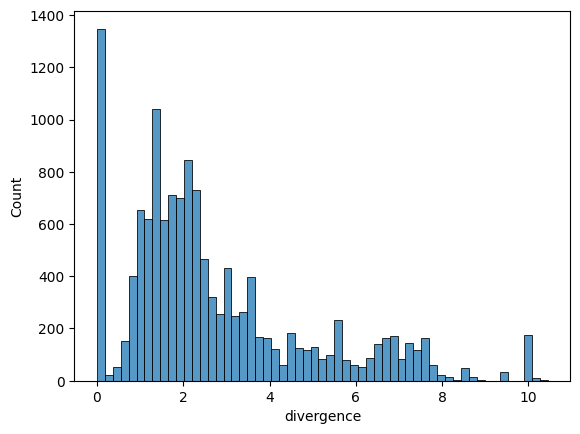

In [39]:
import seaborn as sns
sns.histplot(data=df,x='divergence')

/tmp/ipykernel_516261/3670044194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['trial']=sub_df['trial']/np.max(sub_df['likelihood'])


<Axes: xlabel='time', ylabel='likelihood'>

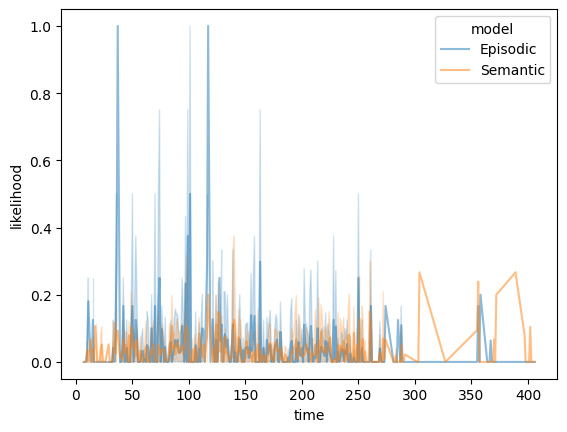

In [70]:
import seaborn as sns
sub_df=df[df['divergence']>5]
sub_df['trial']=sub_df['trial']/np.max(sub_df['likelihood'])
sns.lineplot(data=sub_df,x='time',y='likelihood',hue='model',alpha=0.5)
#sns.lineplot(data=sub_df,x='time',y='trial')